In [12]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import load_model, Model
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from datetime import datetime
from misc.utils import generate_generator, gen_imgPaths_and_labelPaths, monitor_mae, monitor_mse, \
                       sample_predictions, first_predictions, calc_mae_mse, get_profile
from keras.layers import Conv2D, MaxPooling2D, Concatenate, Input, SeparableConv2D, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

from models import MCNN

%matplotlib inline
np.random.seed(123)

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_img, train_labels, test_img, test_labels \
= (
    np.load('./npy/train_img.npy'),
    np.load('./npy/train_labels.npy'),
    np.load('./npy/test_img.npy'),
    np.load('./npy/test_labels.npy')
)

test_img, validation_img, test_labels, validation_labels = train_test_split(test_img, test_labels, test_size=0.5, random_state=24)

In [4]:
def test_model(weights=None, input_shape=(None, None, 1)):
    input_flow = Input(shape=input_shape)
    branches = []

    # large
    f = 16
    k = 9

    x = Conv2D(f, (k, k), padding='same', activation='relu')(input_flow)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(f*2, (k-2, k-2), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(f, (k-2, k-2), padding='same', activation='relu')(x)
    x = Conv2D(f//2, (k-2, k-2), padding='same', activation='relu')(x)

    branches.append(x)

    # medium
    f = 20
    k = 7

    x = Conv2D(f, (k, k), padding='same', activation='relu')(input_flow)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(f*2, (k-2, k-2), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(f, (k-2, k-2), padding='same', activation='relu')(x)
    x = Conv2D(f//2, (k-2, k-2), padding='same', activation='relu')(x)

    branches.append(x)

    # small
    f = 24
    k = 5

    x = Conv2D(f, (k, k), padding='same', activation='relu')(input_flow)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(f*2, (k-2, k-2), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(f, (k-2, k-2), padding='same', activation='relu')(x)
    x = Conv2D(f//2, (k-2, k-2), padding='same', activation='relu')(x)

    branches.append(x)

    merged_feature_maps = Concatenate(axis=3)(branches)
    density_map = Conv2D(1, (1, 1), padding='same')(merged_feature_maps)
    model = Model(inputs=input_flow, outputs=density_map)

    return model

model = test_model()

In [5]:
# =================================================================
# CONFIG
# =================================================================
model_name = 'test'
submodel_name = 'with_l2'
dataset = "shhb"
epochs = 100
batch_size = 50
# =================================================================

weights_val_path = f'./weights/{model_name}_{submodel_name}_{dataset}_val.hdf5'
checkpointer_best_val = ModelCheckpoint(
    filepath=weights_val_path,
    monitor='val_loss', verbose=0, save_best_only=True, mode='min'
)

weights_train_path = f'./weights/{model_name}_{submodel_name}_{dataset}_train.hdf5'
checkpointer_best_train = ModelCheckpoint(
    filepath=weights_train_path,
    monitor='loss', verbose=0, save_best_only=True, mode='min'
)

checkpointer_tensorboard = TensorBoard(
    log_dir='./exp/'+f"{datetime.now().strftime('%Y%m%d_%H:%M')}_{model_name}_{submodel_name}_{dataset}"
)

model._get_distribution_strategy = lambda: None
adam = Adam()
model.compile(loss='mean_squared_error', optimizer=adam, metrics=[monitor_mae, monitor_mse])

In [6]:
# if os.path.exists('./exp/'):
#     shutil.rmtree('./exp/')
#     os.makedirs('./exp/')
    
if os.path.exists(weights_val_path):
    os.remove(weights_val_path)

if os.path.exists(weights_train_path):
    os.remove(weights_train_path)

# Training
model._get_distribution_strategy = lambda: None
history = model.fit(
    x=train_img, y=train_labels, batch_size=batch_size, epochs=epochs, shuffle= True,
    validation_data=(validation_img, validation_labels),
    callbacks=[checkpointer_best_val, checkpointer_best_train, checkpointer_tensorboard],
    verbose=0
)

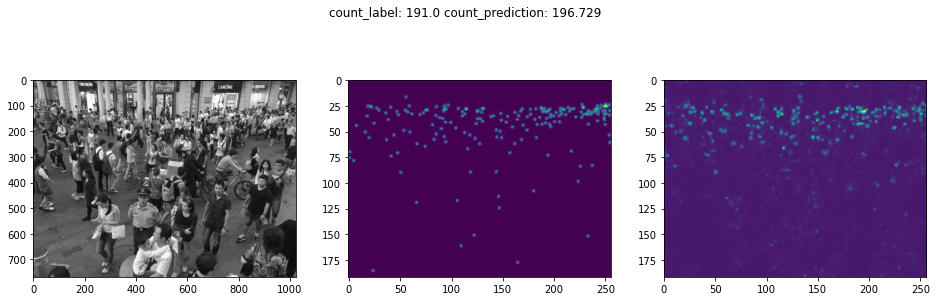

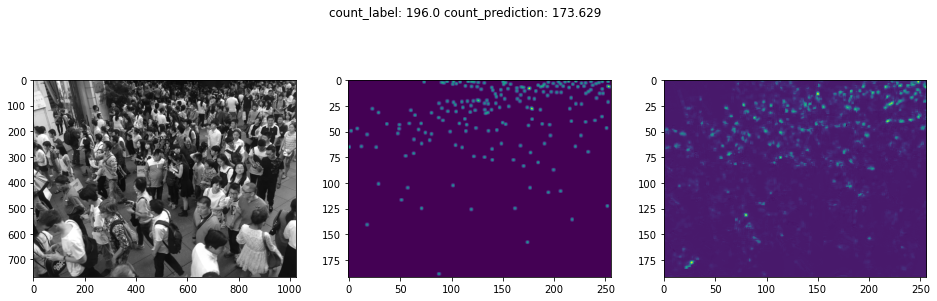

MAE: 29.48 RMSE: 47.76


In [7]:
weights_path = f'./weights/test_0_shhb_val.hdf5'  # {test_0_shhb_val,
                                                        #  test_0_shhb_train}
model = load_model(weights_path, custom_objects={
                    'monitor_mae': monitor_mae, 'monitor_mse': monitor_mse})

first_predictions(validation_img, validation_labels, model, 2)
calc_mae_mse(validation_img, validation_labels, model)

In [15]:
def test_model(weights=None, input_shape=(None, None, 1)):
    input_flow = Input(shape=input_shape)
    branches = []

    # large
    f = 16
    k = 9

    x = Conv2D(f, (k, k), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5))(input_flow)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(f*2, (k-2, k-2), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(f, (k-2, k-2), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5))(x)
    x = Conv2D(f//2, (k-2, k-2), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5))(x)

    branches.append(x)

    # medium
    f = 20
    k = 7

    x = Conv2D(f, (k, k), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5))(input_flow)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(f*2, (k-2, k-2), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(f, (k-2, k-2), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5))(x)
    x = Conv2D(f//2, (k-2, k-2), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5))(x)

    branches.append(x)

    # small
    f = 24
    k = 5

    x = Conv2D(f, (k, k), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5))(input_flow)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(f*2, (k-2, k-2), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(f, (k-2, k-2), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5))(x)
    x = Conv2D(f//2, (k-2, k-2), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5))(x)

    branches.append(x)

    merged_feature_maps = Concatenate(axis=3)(branches)
    density_map = Conv2D(1, (1, 1), padding='same')(merged_feature_maps)
    model = Model(inputs=input_flow, outputs=density_map)

    return model

model = test_model()

In [16]:
# =================================================================
# CONFIG
# =================================================================
model_name = 'test'
submodel_name = 'with_l2'
dataset = "shhb"
epochs = 100
batch_size = 50
# =================================================================

weights_val_path = f'./weights/{model_name}_{submodel_name}_{dataset}_val.hdf5'
checkpointer_best_val = ModelCheckpoint(
    filepath=weights_val_path,
    monitor='val_loss', verbose=0, save_best_only=True, mode='min'
)

weights_train_path = f'./weights/{model_name}_{submodel_name}_{dataset}_train.hdf5'
checkpointer_best_train = ModelCheckpoint(
    filepath=weights_train_path,
    monitor='loss', verbose=0, save_best_only=True, mode='min'
)

checkpointer_tensorboard = TensorBoard(
    log_dir='./exp/'+f"{datetime.now().strftime('%Y%m%d_%H:%M')}_{model_name}_{submodel_name}_{dataset}"
)

model._get_distribution_strategy = lambda: None
adam = Adam()
model.compile(loss='mean_squared_error', optimizer=adam, metrics=[monitor_mae, monitor_mse])

In [17]:
# if os.path.exists('./exp/'):
#     shutil.rmtree('./exp/')
#     os.makedirs('./exp/')
    
if os.path.exists(weights_val_path):
    os.remove(weights_val_path)

if os.path.exists(weights_train_path):
    os.remove(weights_train_path)

# Training
model._get_distribution_strategy = lambda: None
history = model.fit(
    x=train_img, y=train_labels, batch_size=batch_size, epochs=epochs, shuffle= True,
    validation_data=(validation_img, validation_labels),
    callbacks=[checkpointer_best_val, checkpointer_best_train, checkpointer_tensorboard],
    verbose=0
)

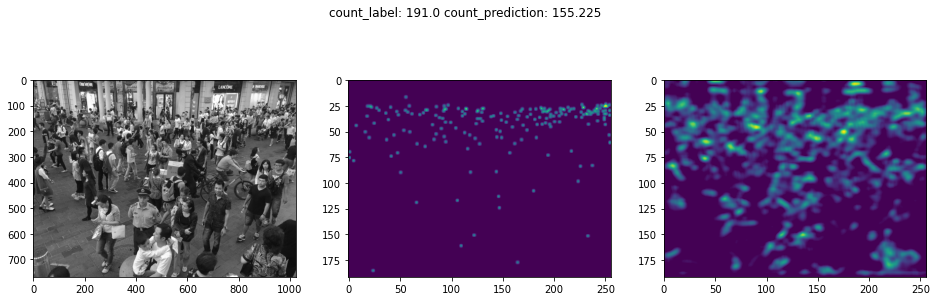

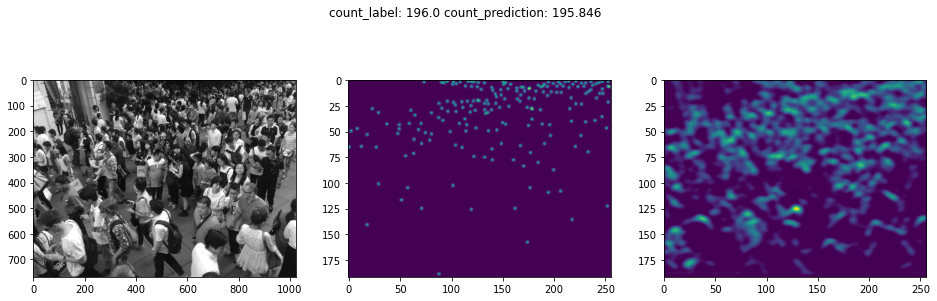

MAE: 54.41 RMSE: 76.68


In [18]:
weights_path = f'./weights/test_with_l2_shhb_val.hdf5'
model = load_model(weights_path, custom_objects={
                    'monitor_mae': monitor_mae, 'monitor_mse': monitor_mse})

first_predictions(validation_img, validation_labels, model, 2)
calc_mae_mse(validation_img, validation_labels, model)

In [27]:
def test_model(weights=None, input_shape=(None, None, 1)):
    input_flow = Input(shape=input_shape)
    branches = []

    reg_factor = 1e-9
    
    # large
    f = 16
    k = 9

    x = Conv2D(f, (k, k), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=reg_factor))(input_flow)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(f*2, (k-2, k-2), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=reg_factor))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(f, (k-2, k-2), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=reg_factor))(x)
    x = Conv2D(f//2, (k-2, k-2), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=reg_factor))(x)

    branches.append(x)

    # medium
    f = 20
    k = 7

    x = Conv2D(f, (k, k), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=reg_factor))(input_flow)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(f*2, (k-2, k-2), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=reg_factor))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(f, (k-2, k-2), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=reg_factor))(x)
    x = Conv2D(f//2, (k-2, k-2), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=reg_factor))(x)

    branches.append(x)

    # small
    f = 24
    k = 5

    x = Conv2D(f, (k, k), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=reg_factor))(input_flow)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(f*2, (k-2, k-2), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=reg_factor))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(f, (k-2, k-2), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=reg_factor))(x)
    x = Conv2D(f//2, (k-2, k-2), padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=reg_factor))(x)

    branches.append(x)

    merged_feature_maps = Concatenate(axis=3)(branches)
    density_map = Conv2D(1, (1, 1), padding='same')(merged_feature_maps)
    model = Model(inputs=input_flow, outputs=density_map)

    return model

model = test_model()

In [30]:
# =================================================================
# CONFIG
# =================================================================
model_name = 'test'
submodel_name = 'with_l2_smaller'
dataset = "shhb"
epochs = 200
batch_size = 50
# =================================================================

weights_val_path = f'./weights/{model_name}_{submodel_name}_{dataset}_val.hdf5'
checkpointer_best_val = ModelCheckpoint(
    filepath=weights_val_path,
    monitor='val_loss', verbose=0, save_best_only=True, mode='min'
)

weights_train_path = f'./weights/{model_name}_{submodel_name}_{dataset}_train.hdf5'
checkpointer_best_train = ModelCheckpoint(
    filepath=weights_train_path,
    monitor='loss', verbose=0, save_best_only=True, mode='min'
)

checkpointer_tensorboard = TensorBoard(
    log_dir='./exp/'+f"{datetime.now().strftime('%Y%m%d_%H:%M')}_{model_name}_{submodel_name}_{dataset}"
)

model._get_distribution_strategy = lambda: None
adam = Adam()
model.compile(loss='mean_squared_error', optimizer=adam, metrics=[monitor_mae, monitor_mse])

In [31]:
# if os.path.exists('./exp/'):
#     shutil.rmtree('./exp/')
#     os.makedirs('./exp/')
    
if os.path.exists(weights_val_path):
    os.remove(weights_val_path)

if os.path.exists(weights_train_path):
    os.remove(weights_train_path)

# Training
model._get_distribution_strategy = lambda: None
history = model.fit(
    x=train_img, y=train_labels, batch_size=batch_size, epochs=epochs, shuffle= True,
    validation_data=(validation_img, validation_labels),
    callbacks=[checkpointer_best_val, checkpointer_best_train, checkpointer_tensorboard],
    verbose=0
)

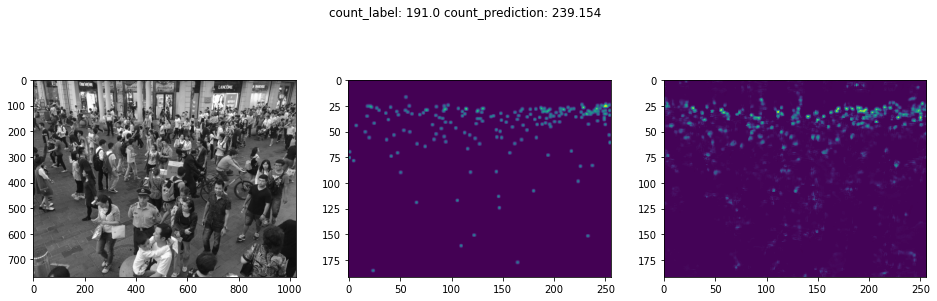

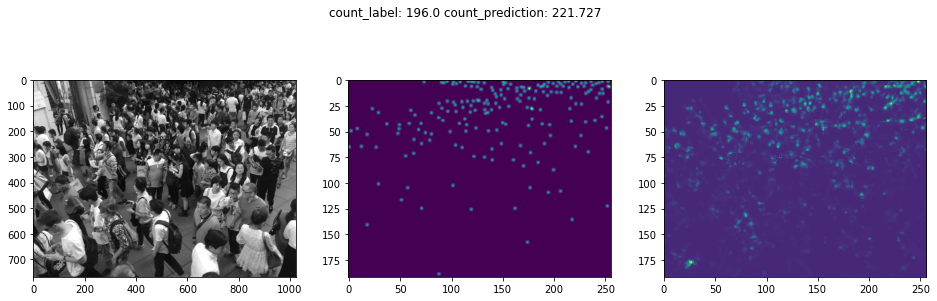

MAE: 38.34 RMSE: 47.95


In [32]:
weights_path = f'./weights/test_with_l2_smaller_shhb_val.hdf5'
model = load_model(weights_path, custom_objects={
                    'monitor_mae': monitor_mae, 'monitor_mse': monitor_mse})

first_predictions(validation_img, validation_labels, model, 2)
calc_mae_mse(validation_img, validation_labels, model)

## Final test

In [ ]:
# weights_path = f'./weights/mae_36.13_mcnn_base_shhb_val.hdf5'  # {mcnn_base_shhb_train,
#                                                      #  mcnn_base_shhb_val}
# model = load_model(weights_path, custom_objects={
#                     'monitor_mae': monitor_mae, 'monitor_mse': monitor_mse})
# sample_predictions(test_img, test_labels, model, 2)
# calc_mae_mse(test_img, test_labels, model)